In [3]:
import pandas as pd
import pandahouse as ph
import scipy.stats as stats
from scipy.stats import ttest_ind
import seaborn as sns
import numpy as np
import hashlib
import matplotlib.pyplot as plt

In [4]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-31' and '2023-02-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()


,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [1]:
# Группы разбиты примерно одинаково, это хорошо.

In [4]:
# T-test
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

In [ ]:
# Вроде средние CTR равны, мы не отвергаем Н0

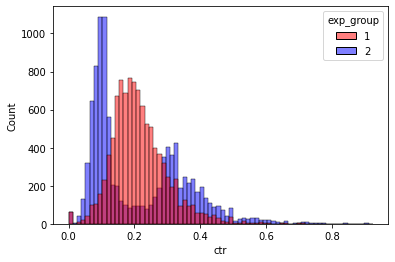

In [7]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [ ]:
# Различия в распределениях CTR очевидны, группа 2 имеет 2 вершины, и опираться на Т-тест 
# в этом случае не верно. Посмотрим что нам покажет тест Манна-Уитни.

In [7]:
print(stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                         df[df.exp_group == 2].ctr,
                         alternative = 'two-sided'))

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)
В 55.37 % случаев A > B. Должно получиться около 50%


In [ ]:
# Тест показывает значимые различия CTR между группами, отвергаем Н0.

# Надо проверить на сглаженносм CTR. Общегрупповой CTR поможет уровнять просмотры и лайки.

In [10]:
# функция для сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr


In [9]:
# Общегрупповой CTR
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()


<AxesSubplot:xlabel='ctr'>

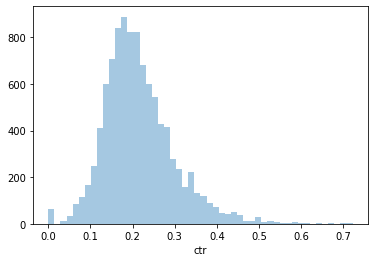

In [15]:
# Посмотрим на CTR группы 1
group1 = df[df.exp_group == 1].copy()

sns.distplot(group1.ctr, 
             kde = False)

In [ ]:
# Есть выбросы как со стороны 0, так и больших значений

<AxesSubplot:xlabel='smothed_ctr'>

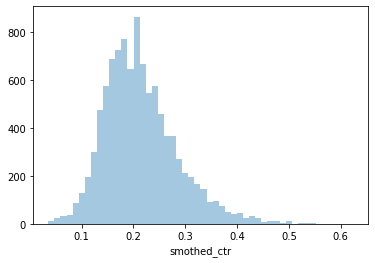

In [16]:
# Примим альфу = 5 и посчитаем сглаженный CTR для группы 1
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr, 
             kde = False)

In [ ]:
# Видно, что крайние значения немного сгладились

<AxesSubplot:xlabel='ctr'>

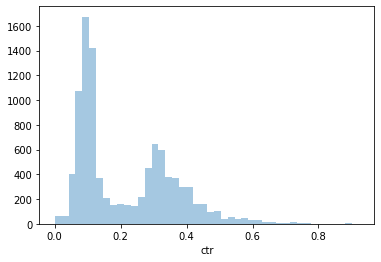

In [17]:
# Посмотрим на CTR группы 2
group2 = df[df.exp_group == 2].copy()

sns.distplot(group2.ctr, 
             kde = False)

<AxesSubplot:xlabel='smothed_ctr'>

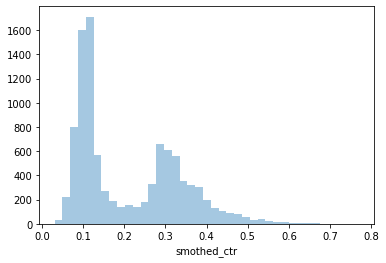

In [18]:
# Примим альфу = 5 и посчитаем сглаженный CTR для группы 2
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.smothed_ctr, 
             kde = False)

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='smothed_ctr', ylabel='Density'>

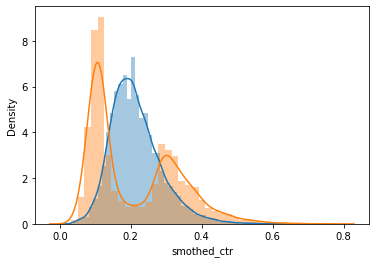

In [25]:
sns.distplot(group1.smothed_ctr) # голубая
sns.distplot(group2.smothed_ctr)

In [26]:
# T-test
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [ ]:
# T-тест < 0,05, отвергаем H0. Но доверять этому нельзя, т.к. наше рапредеделение средних 
# CTR во 2й группе сильно скошено

In [19]:
# Проведем тест Манна-Уитни
stats.mannwhitneyu(group1.smothed_ctr, 
                   group2.smothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

In [ ]:
#По прежнему группы имеют отличия.Отвергаем Н0.

In [ ]:
#Посмотрим что нам покажет Бутстреп.

In [3]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


In [4]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [5]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)


<AxesSubplot:ylabel='Count'>

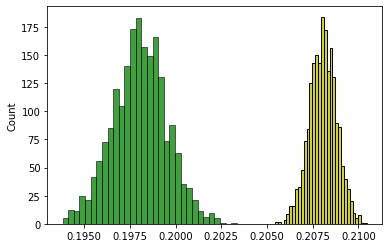

In [6]:
sns.histplot(ctr1, color='y')
sns.histplot(ctr2, color='g')

In [10]:
# Средние значения у группы 1 выше и более точечные.
# При такой разнице наше p-value группового CTR будет равно 0, т.к. наши данные не пересекаются.

<AxesSubplot:ylabel='Count'>

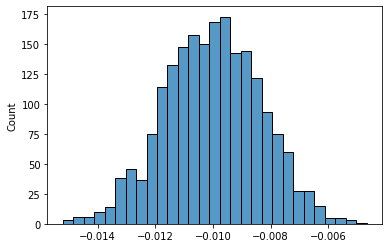

In [8]:
#Посмотрим на разница между глобальными CTR.
sns.histplot(ctr2 - ctr1)

In [ ]:
# Что и требовалось доказать, глобальный CTR в одной группе строго больше чем в другой, 
# значение не пересекают значение 0. 
# Группа 1 (контрольня) показала лучшие значения, чем группа 2 (тестовая). 

In [ ]:
# Проверим данные с помощью побакетного преобразования

In [15]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-01-31' and '2023-02-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(q, connection=connection)


In [16]:
# Посмотрим средний побакетный CTR по тесту Манна-Уитни, 
# учитывая что у нас нет нормальности в распределениях
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [29]:
# Но на всякий случай посмотрим на Т-тест
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr,
                df[df.exp_group == 2].bucket_ctr,
                equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [27]:
# Тесты показали значимые различия наших групп. Отвергаем H0.

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

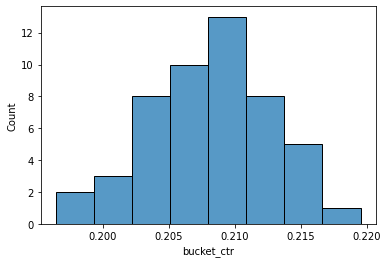

In [18]:
# Посмотрим на бакетное распределение CTR группы 1
sns.histplot(df[df.exp_group == 1].bucket_ctr)

In [ ]:
# Есть что-то похожее на нормальное распределение, но это не точно

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

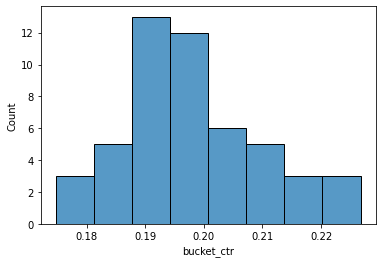

In [19]:
# Бакетное распределение CTR группы 2
sns.histplot(df[df.exp_group == 2].bucket_ctr)

In [ ]:
# Не очень похоже на нормальное

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

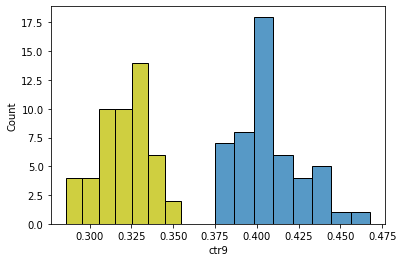

In [25]:
# Посмотрим на бакетное распределение 90% квантиля 
sns.histplot(df[df.exp_group == 1].ctr9, color='y')
sns.histplot(df[df.exp_group == 2].ctr9)

In [30]:
# Проверим бакетное распределение 90% квантиля на тесте Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].ctr9, 
                   df[df.exp_group == 2].ctr9, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.344839189967265e-18)

In [ ]:
# Мы видим, что группы совершенно разные. Отвергаем Н0.

In [ ]:
Подведем итоги нашего анализа.

В эксперименте участвовали 1 и 2 группы. Группа 1 была контрольная, на группе 2 тестировали новый
алгоритм рекомендаций постов. Период эксперимента неделя с 2023-01-31 по 2023-02-06.

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.

По итогам тестирования, можно сказать, что новые алгоритмы не работают на увеличение CTR. 
Возможно не качественно был проведен АА тест, группы совершенно разные. Или алгоритмы были слишком 
агрессивные (не удобными) и пользователи потеряли интерес.

Визуально распределение значений тестовой группы не похожи на нормальные и опираться на T-testa я 
бы не рекомндовала. Тест Манна-Уитни тоже показывал, что наши группы отличаются. В оценки нашего 
эксперимента должен отлично подойти Пуассоновский бутстреп для подсчета разницы в CTR. Мы провели 
псевдовыборку 2000 раз,и наши группы даже не пересеклись, а глобавльные CTR контрольной группы 
увеличился. Проведя бакетное преобразованиемы убедились, что значения CTR тестовой группы меньше 
контрольной.

Рекомендую не раскатывать новый алгоритм.